In [52]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [53]:
filename = 'minecraft-state'

outfile_path = os.getcwd() + '/' + filename + '.csv'

df = pd.read_csv(outfile_path)
print(df['Label'].value_counts())
print('df shape: {}'.format(df.shape))
df

0.0    325
1.0    324
2.0    324
Name: Label, dtype: int64
df shape: (973, 989)


,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_q1_0,lag1_mean_q1_1,lag1_mean_q1_2,lag1_mean_q1_3,lag1_mean_q2_0,lag1_mean_q2_1,lag1_mean_q2_2,lag1_mean_q2_3,lag1_mean_d_q1q2_0,lag1_mean_d_q1q2_1,lag1_mean_d_q1q2_2,lag1_mean_d_q1q2_3,lag1_mean_d_q1q3_0,lag1_mean_d_q1q3_1,lag1_mean_d_q1q3_2,lag1_mean_d_q1q3_3,lag1_mean_d_q1q4_0,lag1_mean_d_q1q4_1,lag1_mean_d_q1q4_2,lag1_mean_d_q1q4_3,lag1_mean_d_q2q3_0,lag1_mean_d_q2q3_1,lag1_mean_d_q2q3_2,lag1_mean_d_q2q3_3,lag1_mean_d_q2q4_0,lag1_mean_d_q2q4_1,lag1_mean_d_q2q4_2,lag1_mean_d_q2q4_3,lag1_std_0,lag1_std_1,lag1_std_2,lag1_std_3,...,freq_345_3,freq_355_3,freq_365_3,freq_375_3,freq_385_3,freq_395_3,freq_405_3,freq_416_3,freq_426_3,freq_436_3,freq_446_3,freq_456_3,freq_466_3,freq_476_3,freq_486_3,freq_517_3,freq_527_3,freq_537_3,freq_547_3,freq_557_3,freq_568_3,freq_578_3,freq_588_3,freq_598_3,freq_608_3,freq_618_3,freq_628_3,freq_639_3,freq_649_3,freq_659_3,freq_669_3,freq_679_3,freq_689_3,freq_699_3,freq_709_3,freq_720_3,freq_730_3,freq_740_3,freq_750_3,Label
0,-32.154915,-38.225452,-28.599344,-30.135834,6.803057,5.225593,1.649192,4.854986,-32.617780,-42.057168,-27.494704,-28.341291,-38.417774,-39.651406,-31.302407,-36.674256,5.799994,-2.405762,3.807703,8.332965,-1.851539,-7.721907,1.856150,1.179339,-5.824278,-5.200734,-1.254586,-2.397548,-7.651533,-5.316145,-1.951553,-7.153626,-11.624272,-2.794973,-5.062289,-10.730513,28.816915,18.593763,18.849429,35.752691,...,0.017202,0.016973,0.015967,0.022701,0.012251,0.015062,0.014078,0.022655,0.024247,0.002683,0.001663,0.036528,0.022276,0.025368,0.028232,0.029194,0.018445,0.029154,0.054118,0.048679,0.067469,0.095822,0.131813,0.418110,0.505693,0.160135,0.070051,0.049708,0.051429,0.013104,0.037577,0.026346,0.038671,0.044081,0.030746,0.012169,0.016596,0.012201,0.013379,2.0
1,-35.142831,-39.223388,-27.766906,-34.991569,2.398636,-2.235254,2.033929,4.384926,-43.317410,-39.067399,-29.355277,-41.195990,-29.550449,-37.169430,-28.227501,-33.277651,-13.766961,-1.897969,-1.127776,-7.918339,-0.781135,1.680851,-2.052391,0.943831,-17.740532,0.877098,-3.143729,-17.491791,12.985826,3.578820,-0.924615,8.862170,-3.973571,2.775067,-2.015953,-9.573453,30.021050,14.937625,12.898872,30.251720,...,0.007380,0.038325,0.019385,0.015440,0.004249,0.022031,0.020526,0.027515,0.012452,0.035881,0.021636,0.024455,0.023262,0.021025,0.007073,0.005408,0.018415,0.026102,0.026433,0.020608,0.022332,0.033131,0.070544,0.096422,0.272728,0.119921,0.063087,0.014464,0.004120,0.029663,0.004435,0.022129,0.013027,0.003004,0.015533,0.022746,0.012299,0.007075,0.024237,1.0
2,-32.548954,-40.783730,-30.661788,-33.093772,-2.622299,-2.152502,0.231816,0.484548,-31.462627,-38.090302,-29.296960,-30.340881,-31.018898,-41.282098,-32.219464,-36.252391,-0.443729,3.191796,2.922504,5.911510,1.671443,1.437924,1.974689,0.278147,3.104404,6.040073,0.542249,4.684337,2.115172,-1.753872,-0.947815,-5.633362,3.548133,2.848276,-2.380255,-1.227173,28.077509,18.307230,18.275841,35.205481,...,0.028623,0.031915,0.014750,0.015222,0.029838,0.014958,0.022739,0.009980,0.037242,0.014858,0.010897,0.030828,0.007305,0.002504,0.003168,0.004004,0.019790,0.006940,0.029879,0.035646,0.053611,0.049915,0.096609,0.195696,0.668912,0.144535,0.107760,0.053032,0.036844,0.046871,0.034697,0.019636,0.024048,0.024585,0.026056,0.032212,0.037245,0.022134,0.021206,2.0
3,-39.512475,-44.579129,-29.252835,-36.577075,-3.722855,-2.184927,1.894596,-1.376476,-29.774390,-39.678152,-31.772935,-34.454201,-45.320424,-47.194956,-28.668721,-37.285719,15.546035,7.516804,-3.104214,2.831519,22.084739,10.177976,-6.257862,10.160243,1.390212,1.919026,-0.750368,-4.344621,6.538704,2.661171,-3.153648,7.328725,-14.155822,-5.597778,2.353846,-7.176140,43.222238,20.904041,17.702335,43.669562,...,0.010473,0.016065,0.016210,0.003900,0.010854,0.016232,0.013264,0.003876,0.003773,0.016036,0.010098,0.002983,0.007249,0.010898,0.012914,0.011434,0.003980,0.015132,0.002280,0.007132,0.020270,0.0

In [54]:
def preprocess_inputs(df):
    df = df.copy()
    
    y = df['Label'].copy()
    X = df.drop('Label', axis=1).copy()
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = preprocess_inputs(df)

In [55]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))

expand_dims = tf.expand_dims(inputs, axis=2)

lstm = tf.keras.layers.LSTM(256, return_sequences=True)(expand_dims)

flatten = tf.keras.layers.Flatten()(lstm)

# consider adding a dense layer after lstm

outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 988)]             0         
_________________________________________________________________
tf.expand_dims_6 (TFOpLambda (None, 988, 1)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 988, 256)          264192    
_________________________________________________________________
flatten_5 (Flatten)          (None, 252928)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 758787    
Total params: 1,022,979
Trainable params: 1,022,979
Non-trainable params: 0
_________________________________________________________________
None


In [56]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    callbacks=[
    ]
)
model.save(os.getcwd() + '/drive/My Drive/lstm_200.h5')

Epoch 1/200
22/22 [==============================] - 65s 3s/step - loss: 6.8974 - accuracy: 0.4038 - val_loss: 1.9541 - val_accuracy: 0.4863
Epoch 2/200
22/22 [==============================] - 63s 3s/step - loss: 1.2276 - accuracy: 0.6241 - val_loss: 0.9806 - val_accuracy: 0.6267
Epoch 3/200
22/22 [==============================] - 63s 3s/step - loss: 0.5335 - accuracy: 0.7474 - val_loss: 0.6332 - val_accuracy: 0.7055
Epoch 4/200
22/22 [==============================] - 62s 3s/step - loss: 0.3845 - accuracy: 0.8267 - val_loss: 0.4758 - val_accuracy: 0.7740
Epoch 5/200
22/22 [==============================] - 63s 3s/step - loss: 0.3880 - accuracy: 0.8223 - val_loss: 1.0351 - val_accuracy: 0.6678
Epoch 6/200
22/22 [==============================] - 63s 3s/step - loss: 0.3188 - accuracy: 0.8605 - val_loss: 0.4496 - val_accuracy: 0.8082
Epoch 7/200
22/22 [==============================] - 63s 3s/step - loss: 0.1434 - accuracy: 0.9457 - val_loss: 0.4072 - val_accuracy: 0.8116
Epoch 8/200
2

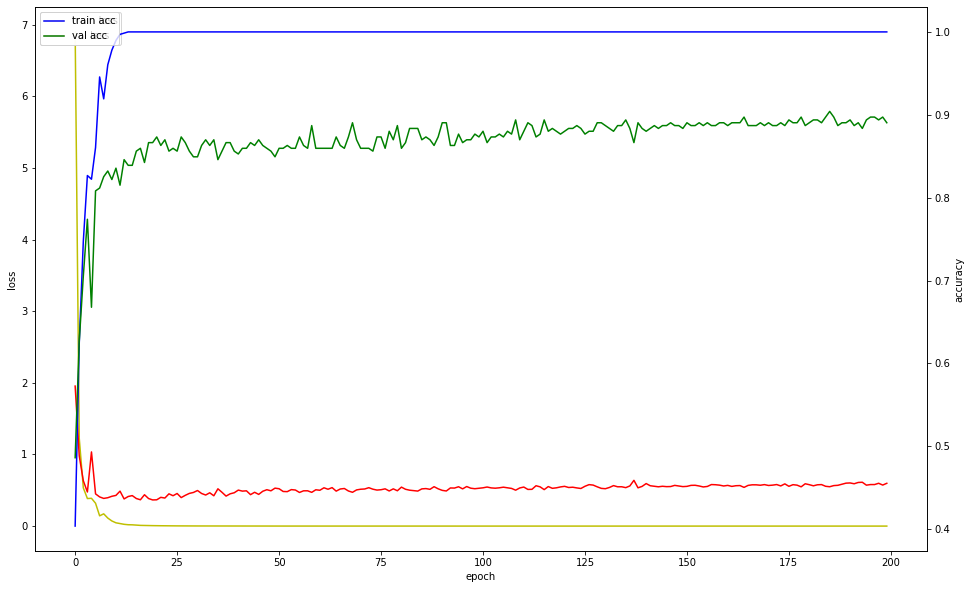

In [57]:
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

Test Accuracy: 89.041%


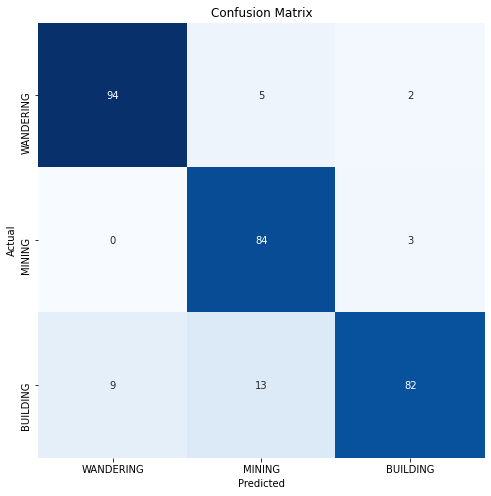

Classification Report:
----------------------
               precision    recall  f1-score   support

   WANDERING       0.91      0.93      0.92       101
      MINING       0.82      0.97      0.89        87
    BUILDING       0.94      0.79      0.86       104

    accuracy                           0.89       292
   macro avg       0.89      0.89      0.89       292
weighted avg       0.90      0.89      0.89       292



In [58]:
model_acc = model.evaluate(X_val, y_val, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

label_mapping = {'WANDERING': 0, 'MINING': 1, 'BUILDING': 2}
y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_val))))

cm = confusion_matrix(y_val, y_pred)
clr = classification_report(y_val, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)